<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-03-13 

CPython 2.7.10
IPython 5.3.0

numpy 1.12.0
matplotlib 2.0.0
scipy 0.15.1
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.5.1


# Laputop reconstruction performance
### Table of contents
1. [Load simulation DataFrame and apply quality cuts](#Load-simulation-DataFrame-and-apply-quality-cuts)
2. [Define functions to be fit to effective area](#Define-functions-to-be-fit-to-effective-area)
3. [Calculate effective areas](#Calculate-effective-areas)
4. [Plot result](#Plot-result)

In [2]:
%matplotlib inline
from __future__ import division, print_function
from collections import defaultdict
import numpy as np
from scipy import optimize
from scipy.stats import chisquare
import pandas as pd
import matplotlib.pyplot as plt
import seaborn.apionly as sns

import composition as comp
import composition.analysis.plotting as plotting

color_dict = comp.analysis.get_color_dict()

/home/jbourbeau/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load simulation DataFrame and apply quality cuts
[ [back to top](#top) ]

In [3]:
df_sim, cut_dict_sim = comp.load_dataframe(datatype='sim', config='IC79', return_cut_dict=True)
selection_mask = np.array([True] * len(df_sim))
standard_cut_keys = ['IceTopQualityCuts', 'lap_InIce_containment']
#                 'num_hits_1_60', 'max_qfrac_1_60',
#                 'InIceQualityCuts']
for cut in ['MilliNCascAbove2', 'MilliQtotRatio', 'MilliRloglBelow2', 'StochRecoSucceeded']:
    standard_cut_keys += ['InIceQualityCuts_{}'.format(cut)]
    
for key in standard_cut_keys:
    selection_mask *= cut_dict_sim[key]
    print(key, np.sum(selection_mask))

df_sim = df_sim[selection_mask]

/home/jbourbeau/cr-composition/composition/dataframe_functions.py:137: RuntimeWarning: divide by zero encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])
/home/jbourbeau/cr-composition/composition/dataframe_functions.py:137: RuntimeWarning: invalid value encountered in log10
  df['log_dEdX'] = np.log10(df['eloss_1500_standard'])


IceTopQualityCuts 398044
lap_InIce_containment 308917
InIceQualityCuts_MilliNCascAbove2 303722
InIceQualityCuts_MilliQtotRatio 298477
InIceQualityCuts_MilliRloglBelow2 298477
InIceQualityCuts_StochRecoSucceeded 298476


#### Define energy binning for this analysis

In [4]:
energy_bins = 10**np.arange(5.0, 9.51, 0.1)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2

energy_min_fit, energy_max_fit = 5.8, 9.5
midpoints_fitmask = (energy_midpoints >= 10**energy_min_fit) & (energy_midpoints <= 10**energy_max_fit)

In [5]:
np.log10(energy_bins)

array([ 5. ,  5.1,  5.2,  5.3,  5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,
        6.1,  6.2,  6.3,  6.4,  6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,
        7.2,  7.3,  7.4,  7.5,  7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,
        8.3,  8.4,  8.5,  8.6,  8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,
        9.4,  9.5])

In [6]:
np.log10(energy_midpoints[midpoints_fitmask])

array([ 5.8528719,  5.9528719,  6.0528719,  6.1528719,  6.2528719,
        6.3528719,  6.4528719,  6.5528719,  6.6528719,  6.7528719,
        6.8528719,  6.9528719,  7.0528719,  7.1528719,  7.2528719,
        7.3528719,  7.4528719,  7.5528719,  7.6528719,  7.7528719,
        7.8528719,  7.9528719,  8.0528719,  8.1528719,  8.2528719,
        8.3528719,  8.4528719,  8.5528719,  8.6528719,  8.7528719,
        8.8528719,  8.9528719,  9.0528719,  9.1528719,  9.2528719,
        9.3528719,  9.4528719])

### Energy resolution

In [7]:
energybins = comp.analysis.get_energybins()

In [8]:
energy_res = df_sim['lap_log_energy'] - df_sim['MC_log_energy']
light_mask = df_sim['MC_comp_class'] == 'light'
heavy_mask = df_sim['MC_comp_class'] == 'heavy'
_, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(df_sim['MC_log_energy'][light_mask],
                                                                           energy_res[light_mask],
                                                                           energybins.log_energy_bins)
_, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(df_sim['MC_log_energy'][heavy_mask],
                                                                           energy_res[heavy_mask],
                                                                           energybins.log_energy_bins)

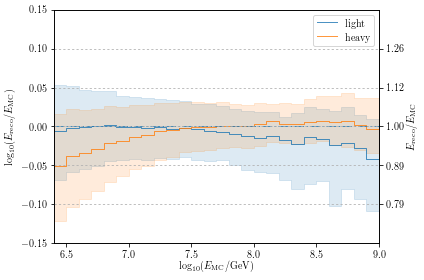

In [10]:
fig, ax = plt.subplots()
# ax.errorbar(energybins.log_energy_midpoints, bin_medians_light, yerr=error_light,
#             marker='.', ls='None', label='light')
# ax.errorbar(energybins.log_energy_midpoints, bin_medians_heavy, yerr=error_heavy,
#             marker='.', ls='None', label='heavy')
plotting.plot_steps(energybins.log_energy_midpoints, bin_medians_light, np.array(error_light), ax,
                        color_dict['light'], 'light')
plotting.plot_steps(energybins.log_energy_midpoints, bin_medians_heavy, np.array(error_heavy), ax,
                        color_dict['heavy'], 'heavy')
ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\log_{10}(E_{\mathrm{reco}}/E_{\mathrm{MC}})$')
ax.set_xlim([6.4, 9.0])
ax.set_ylim([-0.15, 0.15])
ax.legend()
ax2 = ax.twinx()
ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
ax2.set_ylim(list(ax.get_ylim()))
# ax2.axhline(0.1, marker='None', linestyle='-.', color='gray')
# ax2.axhline(-0.1, marker='None', linestyle='-.', color='gray')
plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
plt.grid()
plt.savefig('/home/jbourbeau/public_html/figures/lap-energyres.png')
plt.show()

### Core resolution

In [11]:
core_res = np.sqrt((df_sim['lap_x'] - df_sim['MC_x'])**2+(df_sim['lap_y'] - df_sim['MC_y'])**2)
_, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(df_sim['MC_log_energy'][light_mask],
                                                                           core_res[light_mask],
                                                                           energybins.log_energy_bins)
_, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(df_sim['MC_log_energy'][heavy_mask],
                                                                           core_res[heavy_mask],
                                                                           energybins.log_energy_bins)

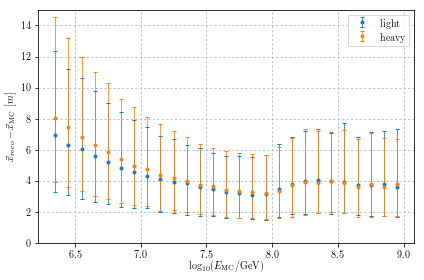

In [12]:
fig, ax = plt.subplots()
ax.errorbar(energybins.log_energy_midpoints, bin_medians_light, yerr=np.array(error_light),
            marker='.', ls='None', label='light')
ax.errorbar(energybins.log_energy_midpoints, bin_medians_heavy, yerr=np.array(error_heavy),
            marker='.', ls='None', label='heavy')
ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\\vec{x}_{\mathrm{reco}}-\\vec{x}_{\mathrm{MC}} \ [m]$')
ax.set_ylim([0, 15])
ax.legend()
# ax2 = ax.twinx()
# ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
# ax2.set_ylim(list(ax.get_ylim()))
# # ax2.axhline(0.1, marker='None', linestyle='-.', color='gray')
# # ax2.axhline(-0.1, marker='None', linestyle='-.', color='gray')
# plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
plt.grid()
plt.savefig('/home/jbourbeau/public_html/figures/lap-coreres.png')
plt.show()

### S125 resolution

In [13]:
energybins = comp.analysis.get_energybins()

In [27]:
log_s125 = df_sim['log_s125']
light_mask = df_sim['MC_comp_class'] == 'light'
heavy_mask = df_sim['MC_comp_class'] == 'heavy'
_, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(df_sim['MC_log_energy'][light_mask],
                                                                           log_s125[light_mask],
                                                                           energybins.log_energy_bins)
_, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(df_sim['MC_log_energy'][heavy_mask],
                                                                           log_s125[heavy_mask],
                                                                           energybins.log_energy_bins)

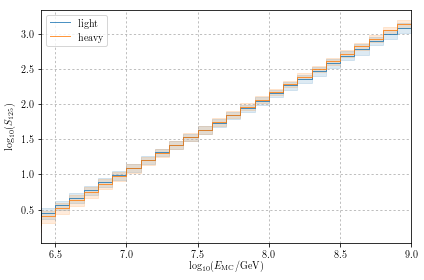

In [28]:
fig, ax = plt.subplots()
# ax.errorbar(energybins.log_energy_midpoints, bin_medians_light, yerr=error_light,
#             marker='.', ls='None', label='light')
# ax.errorbar(energybins.log_energy_midpoints, bin_medians_heavy, yerr=error_heavy,
#             marker='.', ls='None', label='heavy')
plotting.plot_steps(energybins.log_energy_midpoints, bin_medians_light, np.array(error_light), ax,
                        color_dict['light'], 'light')
plotting.plot_steps(energybins.log_energy_midpoints, bin_medians_heavy, np.array(error_heavy), ax,
                        color_dict['heavy'], 'heavy')
# ax.axhline(0, marker='None', linestyle='-.')
ax.set_xlabel('$\log_{10}(E_{\mathrm{MC}}/\mathrm{GeV})$')
ax.set_ylabel('$\log_{10}(S_{\mathrm{125}})$')
ax.set_xlim([6.4, 9.0])
# ax.set_ylim([-0.15, 0.15])
ax.legend()
# ax2 = ax.twinx()
# ax2.set_ylabel('$E_{\mathrm{reco}}/E_{\mathrm{MC}}$')
# ax2.set_ylim(list(ax.get_ylim()))
# # ax2.axhline(0.1, marker='None', linestyle='-.', color='gray')
# # ax2.axhline(-0.1, marker='None', linestyle='-.', color='gray')
# plt.yticks(list(ax.get_yticks())[1:-1], ['{:0.2f}'.format(10**x) for x in ax.get_yticks()[1:-1]])
ax.grid()
plt.savefig('/home/jbourbeau/public_html/figures/lap-energyres.png')
plt.show()